In [1]:
#Imports
import pandas as pd
import os
import tensorflow as tf

import sys  
sys.path.append("../../../")  
from utils.models import *
from utils.datahandling import *
from utils.modelrunner import *

import wandb
import logging
logging.getLogger("wandb").setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
#Get data 
num_users = 30

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Get the first date from the index
start_date = df.index.min()
# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)
# Filter the dataframe to only include the first year of data
df = df[(df.index >= start_date) & (df.index < end_date)]

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

df_array[0]

,User1,temp,rhum,wspd,PC1,hour sin,hour cos,User1_lag_24hrs
Date,,,,,,,,
2010-07-02 00:00:00,0.111,2.5,92.0,0.0,-2.641741,0.000000,1.000000,0.125
2010-07-02 01:00:00,0.346,2.5,92.0,0.0,-2.641741,0.258819,0.965926,0.471
2010-07-02 02:00:00,0.079,2.5,92.0,0.0,-2.641741,0.500000,0.866025,0.121
2010-07-02 03:00:00,0.107,1.0,95.0,3.6,-1.884345,0.707107,0.707107,0.079
2010-07-02 04:00:00,0.120,1.0,95.0,3.6,-1.884345,0.866025,0.500000,0.098
...,...,...,...,...,...,...,...,...
2011-07-01 19:00:00,0.118,12.6,74.0,0.0,-1.499168,-0.965926,0.258819,0.241
2011-07-01 20:00:00,0.276,12.6,74.0,0.0,-1.499168,-0.866025,0.500000,0.256
2011-07-01 21:00:00,0.168,11.2,84.0,0.0,-1.863761,-0.707107,0.707107,0.246


In [3]:
#Hyperparameters
sequence_length = 25
batch_size = 16
num_features = df_array[0].shape[1]
horizon = 1
max_epochs = 100

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min')
timing_callback = TimingCallback()
custom_callback = CustomCallback()

callbacks=[early_stopping, timing_callback, custom_callback]

#Soft dense MoE
dense_smoe_units = 16
dense_smoe_expert_units = 8
dense_smoe_num_experts = 4
dense_smoe_all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])
dense_smoe_results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])

#Soft lstm MoE
lstm_smoe_units = 20
lstm_smoe_expert_units = 8
lstm_smoe_num_experts = 4
lstm_smoe_all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])
lstm_smoe_results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])

#topK dense MoE
dense_topmoe_units = 16
dense_topmoe_num_experts = 5
dense_topmoe_top_k = 2
dense_topmoe_expert_units = 8
dense_topmoe_all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])
dense_topmoe_results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])

#topK lstm MoE
lstm_topmoe_units = 20
lstm_topmoe_num_experts = 5
lstm_topmoe_top_k = 2
lstm_topmoe_expert_units = 8
lstm_topmoe_all_results = pd.DataFrame(columns=["user", "architecture", "train_time", "avg_time_epoch", "mse", "rmse", "mape", "mae"])
lstm_topmoe_results = pd.DataFrame(columns=['architecture', 'train_time', 'avg_time_epoch', 'mse','mse_std', 'rmse','rmse_std','mape','mape_std','mae','mae_std'])

#Train, Validation and Test datasets
X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = min_max_scaling(train_df)
    val_df = min_max_scaling(val_df)
    test_df = min_max_scaling(test_df)

    # Sequencing
    train_sequences = create_sequences(train_df, sequence_length)
    val_sequences = create_sequences(val_df, sequence_length)
    test_sequences = create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = prepare_data(train_sequences, batch_size)
    X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = prepare_data(val_sequences, batch_size)
    X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = prepare_data(test_sequences, batch_size)

In [4]:
run_soft_dense_moe_model (
    wb_project_name = "TS_LL_Grossload_Forecasting_Moe",
    wb_model_name = "dense_soft_with_loss",
    wb_project = "TS_LL_Grossload",
    save_path = os.getcwd(),
    df_array = df_array,
    max_epochs = max_epochs,
    batch_size = batch_size,
    X_train = X_train,
    horizon = horizon, 
    dense_smoe_units = dense_smoe_units, 
    dense_smoe_num_experts = dense_smoe_num_experts, 
    dense_smoe_expert_units = dense_smoe_expert_units, 
    metrics = metrics,
    loss = loss,
    y_train = y_train,
    X_val = X_val,
    y_val = y_val,
    X_test = X_test,
    y_test = y_test,
    callbacks = callbacks,
    results = dense_smoe_results,
    all_results = dense_smoe_all_results,
    use_new_loss=True
)

-----User:  1
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  2
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  3
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  4
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  5
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  6
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  7
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  8
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----Use

In [5]:
run_topk_dense_moe_model(
    wb_project_name = "TS_LL_Grossload_Forecasting_Moe",
    wb_model_name = "dense_topk_with_loss",
    wb_project = "TS_LL_Grossload",
    save_path = os.getcwd(),
    df_array = df_array,
    max_epochs = max_epochs,
    batch_size = batch_size,
    X_train = X_train,
    horizon = horizon, 
    dense_topmoe_units = dense_topmoe_units, 
    dense_topmoe_num_experts = dense_topmoe_num_experts,
    dense_topmoe_top_k = dense_topmoe_top_k,
    dense_topmoe_expert_units = dense_topmoe_expert_units,
    metrics = metrics,
    loss = loss,
    y_train = y_train,
    X_val = X_val,
    y_val = y_val,
    X_test = X_test,
    y_test = y_test,
    callbacks = callbacks,
    results = dense_topmoe_results,
    all_results = dense_topmoe_all_results,
    use_new_loss=True
)

-----User:  1
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  2
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  3
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  4
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  5
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  6
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  7
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  8
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----Use

In [6]:
run_soft_lstm_moe_model(
    wb_project_name = "TS_LL_Grossload_Forecasting_Moe",
    wb_model_name = "lstm_soft_with_loss",
    wb_project = "TS_LL_Grossload",
    save_path = os.getcwd(),
    df_array = df_array,
    max_epochs = max_epochs,
    batch_size = batch_size,
    X_train = X_train,
    horizon = horizon, 
    lstm_smoe_units = lstm_smoe_units, 
    lstm_smoe_num_experts = lstm_smoe_num_experts, 
    lstm_smoe_expert_units = lstm_smoe_expert_units, 
    metrics = metrics,
    loss = loss,
    y_train = y_train,
    X_val = X_val,
    y_val = y_val,
    X_test = X_test,
    y_test = y_test,
    callbacks = callbacks,
    results = lstm_smoe_results,
    all_results = lstm_smoe_all_results,
    use_new_loss=True
)

-----User:  1
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  2
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  3
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  4
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  5
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  6
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  7
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  8
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----Use

In [7]:
run_topk_lstm_moe_model(
        wb_project_name = "TS_LL_Grossload_Forecasting_Moe",
        wb_model_name = "lstm_topk_with_loss",
        wb_project = "TS_LL_Grossload",
        save_path = os.getcwd(),
        df_array = df_array,
        max_epochs = max_epochs,
        batch_size = batch_size,
        X_train = X_train,
        horizon = horizon,  
        lstm_topmoe_units = lstm_topmoe_units, 
        lstm_topmoe_num_experts = lstm_topmoe_num_experts,
        lstm_topmoe_top_k = lstm_topmoe_top_k,
        lstm_topmoe_expert_units = lstm_topmoe_expert_units,
        metrics = metrics,
        loss = loss,
        y_train = y_train,
        X_val = X_val,
        y_val = y_val,
        X_test = X_test,
        y_test = y_test,
        callbacks = callbacks,
        results = lstm_topmoe_results,
        all_results = lstm_topmoe_all_results,
        use_new_loss=True
)

-----User:  1
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  2
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  3
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  4
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  5
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  6
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  7
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----User:  8
Round:  0
saved model
Round:  1
saved model
Round:  2
saved model
Round:  3
saved model
Round:  4
saved model
-----Use

# Evaluation

In [51]:
# Load datasets
dense_soft_no_loss = pd.read_csv("wandb/dense_soft_no_loss_all_results.csv")
dense_topk_no_loss = pd.read_csv("wandb/dense_topk_no_loss_all_results.csv")
lstm_soft_no_loss = pd.read_csv("wandb/lstm_soft_no_loss_all_results.csv")
lstm_topk_no_loss = pd.read_csv("wandb/lstm_topk_no_loss_all_results.csv")

dense_soft_with_loss = pd.read_csv("wandb/dense_soft_with_loss_all_results.csv")
dense_topk_with_loss = pd.read_csv("wandb/dense_topk_with_loss_all_results.csv")
lstm_soft_with_loss = pd.read_csv("wandb/lstm_soft_with_loss_all_results.csv")
lstm_topk_with_loss = pd.read_csv("wandb/lstm_topk_with_loss_all_results.csv")

# Iterate through all 30 users
for user_id in range(1, 31):
    selected = f"user{user_id}"
    
    metric = "mse"
    # Calculate mean RMSE for each model in both settings
    ds_nl_mean = dense_soft_no_loss[dense_soft_no_loss['user'] == selected][metric].mean()
    dt_nl_mean = dense_topk_no_loss[dense_topk_no_loss['user'] == selected][metric].mean()
    ls_nl_mean = lstm_soft_no_loss[lstm_soft_no_loss['user'] == selected][metric].mean()
    lt_nl_mean = lstm_topk_no_loss[lstm_topk_no_loss['user'] == selected][metric].mean()

    ds_wl_mean = dense_soft_with_loss[dense_soft_with_loss['user'] == selected][metric].mean()
    dt_wl_mean = dense_topk_with_loss[dense_topk_with_loss['user'] == selected][metric].mean()
    ls_wl_mean = lstm_soft_with_loss[lstm_soft_with_loss['user'] == selected][metric].mean()
    lt_wl_mean = lstm_topk_with_loss[lstm_topk_with_loss['user'] == selected][metric].mean()

    # Function to calculate percentage improvement
    def calculate_percentage_improvement(no_loss_value, with_loss_value):
        return ((no_loss_value - with_loss_value) / no_loss_value) * 100

    # Count improvements
    min_models_improved = 4
    improvements = 0
    if ds_wl_mean < ds_nl_mean: improvements += 1
    if dt_wl_mean < dt_nl_mean: improvements += 1
    if ls_wl_mean < ls_nl_mean: improvements += 1
    if lt_wl_mean < lt_nl_mean: improvements += 1

    # Check if the improvements meet or exceed the threshold
    if improvements >= min_models_improved:
        print(selected)
        print(f"  Dense Soft: Improvement of {calculate_percentage_improvement(ds_nl_mean, ds_wl_mean):.2f}% (from {ds_nl_mean:.5f} to {ds_wl_mean:.5f})")
        print(f"  Dense TopK: Improvement of {calculate_percentage_improvement(dt_nl_mean, dt_wl_mean):.2f}% (from {dt_nl_mean:.5f} to {dt_wl_mean:.5f})")
        print(f"  LSTM Soft: Improvement of {calculate_percentage_improvement(ls_nl_mean, ls_wl_mean):.2f}% (from {ls_nl_mean:.5f} to {ls_wl_mean:.5f})")
        print(f"  LSTM TopK: Improvement of {calculate_percentage_improvement(lt_nl_mean, lt_wl_mean):.2f}% (from {lt_nl_mean:.5f} to {lt_wl_mean:.5f})\n")

user25
  Dense Soft: Improvement of 3.67% (from 0.03957 to 0.03811)
  Dense TopK: Improvement of 0.70% (from 0.03824 to 0.03798)
  LSTM Soft: Improvement of 1.26% (from 0.03660 to 0.03614)
  LSTM TopK: Improvement of 13.39% (from 0.04744 to 0.04109)

user27
  Dense Soft: Improvement of 2.66% (from 0.01120 to 0.01090)
  Dense TopK: Improvement of 1.52% (from 0.01106 to 0.01089)
  LSTM Soft: Improvement of 3.85% (from 0.01084 to 0.01042)
  LSTM TopK: Improvement of 6.03% (from 0.01084 to 0.01019)



In [40]:
dense_soft = pd.read_csv("wandb/dense_soft_no_loss_all_results.csv")
dense_topk = pd.read_csv("wandb/dense_topk_no_loss_all_results.csv")
lstm_soft = pd.read_csv("wandb/lstm_soft_no_loss_all_results.csv")
lstm_topk = pd.read_csv("wandb/lstm_topk_no_loss_all_results.csv")

selected = "user27"
print("No loss")
print("dense_soft: ", dense_soft[dense_soft['user'] == selected]["rmse"].mean().round(5), dense_soft["rmse"].std().round(5))
print("dense_topk: ", dense_topk[dense_soft['user'] == selected]["rmse"].mean().round(5), dense_topk["rmse"].std().round(5))
print("lstm_soft: ", lstm_soft[dense_soft['user'] == selected]["rmse"].mean().round(5), lstm_soft["rmse"].std().round(5))
print("lstm_topk: ", lstm_topk[dense_soft['user'] == selected]["rmse"].mean().round(5), lstm_topk["rmse"].std().round(5))

No loss
dense_soft:  0.10573 0.02657
dense_topk:  0.10507 0.02539
lstm_soft:  0.10405 0.02563
lstm_topk:  0.1041 0.02847


In [41]:
dense_soft = pd.read_csv("wandb/dense_soft_with_loss_all_results.csv")
dense_topk = pd.read_csv("wandb/dense_topk_with_loss_all_results.csv")
lstm_soft = pd.read_csv("wandb/lstm_soft_with_loss_all_results.csv")
lstm_topk = pd.read_csv("wandb/lstm_topk_with_loss_all_results.csv")

print("With loss")
print("dense_soft: ", dense_soft[dense_soft['user'] == selected]["rmse"].mean().round(5), dense_soft["rmse"].std().round(5))
print("dense_topk: ", dense_topk[dense_soft['user'] == selected]["rmse"].mean().round(5), dense_topk["rmse"].std().round(5))
print("lstm_soft: ", lstm_soft[dense_soft['user'] == selected]["rmse"].mean().round(5), lstm_soft["rmse"].std().round(5))
print("lstm_topk: ", lstm_topk[dense_soft['user'] == selected]["rmse"].mean().round(5), lstm_topk["rmse"].std().round(5))

With loss
dense_soft:  0.10432 0.02668
dense_topk:  0.10433 0.02582
lstm_soft:  0.10207 0.02551
lstm_topk:  0.10087 0.02756


# Evaluation

In [12]:
num_users = 30
sequence_length = 25
batch_size = 16
horizon = 1
max_epochs = 100

loss = tf.keras.losses.MeanSquaredError()
metrics=[
    tf.keras.metrics.RootMeanSquaredError(), 
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanAbsoluteError(),
]

custom_objects = {
                'EinsumLayer': EinsumLayer,
                'TopKLayer': TopKLayer,
                'ImportanceRegularizationLayer': ImportanceRegularizationLayer
                }

In [15]:
cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
df = pd.read_csv(cwd+'/data/3final_data/Final_Grossload_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Get the first date from the index
start_date = df.index.min()
# Calculate the end date as one year from the start date
end_date = start_date + pd.DateOffset(years=1)
# Filter the dataframe to only include the first year of data
df = df[(df.index >= start_date) & (df.index < end_date)]

df_array = []
for idx in range(num_users):
    df_array.append(df[[f'User{idx+1}', 'temp', 'rhum', 'wspd', 'PC1', 'hour sin', 'hour cos', f'User{idx+1}_lag_24hrs']])

In [18]:
#Train, Validation and Test datasets
X_train, y_train, X_val, y_val, X_test, y_test = {}, {}, {}, {}, {}, {}

#Create Train, Validation and Test datasets
for idx, df in enumerate(df_array):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Min max sclaing
    train_df = min_max_scaling(train_df)
    val_df = min_max_scaling(val_df)
    test_df = min_max_scaling(test_df)

    # Sequencing
    train_sequences = create_sequences(train_df, sequence_length)
    val_sequences = create_sequences(val_df, sequence_length)
    test_sequences = create_sequences(test_df, sequence_length)

    #Split into feature and label
    X_train[f'user{idx+1}'], y_train[f'user{idx+1}'] = prepare_data(train_sequences, batch_size)
    X_val[f'user{idx+1}'], y_val[f'user{idx+1}'] = prepare_data(val_sequences, batch_size)
    X_test[f'user{idx+1}'], y_test[f'user{idx+1}'] = prepare_data(test_sequences, batch_size)

53/53 [==============================] - 0s 3ms/step


In [28]:
number = 11
user = 'user' + str(number)

#No loss
dense_soft_model = tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_dense_soft_no_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
dense_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

dense_topk_model = tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_dense_topk_no_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
dense_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_soft_model =  tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_lstm_soft_no_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
bilstm_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_topk_model =  tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_lstm_topk_no_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
bilstm_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

pred_dense_soft_model = dense_soft_model.predict(X_test[user], batch_size=batch_size)
pred_dense_topk_model = dense_topk_model.predict(X_test[user], batch_size=batch_size)
pred_bilstm_soft_model = bilstm_soft_model.predict(X_test[user], batch_size=batch_size)
pred_bilstm_topk_model = bilstm_topk_model.predict(X_test[user], batch_size=batch_size)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Assuming y_test[user] contains the true values
true_values = y_test[user]

# Calculate RMSE for each model
rmse_dense_soft_model = rmse(pred_dense_soft_model, true_values)
rmse_dense_topk_model = rmse(pred_dense_topk_model, true_values)
rmse_bilstm_soft_model = rmse(pred_bilstm_soft_model, true_values)
rmse_bilstm_topk_model = rmse(pred_bilstm_topk_model, true_values)

# Print the RMSE values
print("No loss", rmse_dense_soft_model)
print("RMSE for Dense Soft Model:", rmse_dense_soft_model)
print("RMSE for Dense TopK Model:", rmse_dense_topk_model)
print("RMSE for BiLSTM Soft Model:", rmse_bilstm_soft_model)
print("RMSE for BiLSTM TopK Model:", rmse_bilstm_topk_model)


#Loss
dense_soft_model = tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_dense_soft_with_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
dense_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

dense_topk_model = tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_dense_topk_with_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
dense_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_soft_model =  tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_lstm_soft_with_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
bilstm_soft_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

bilstm_topk_model =  tf.keras.models.load_model(cwd + f"/src/time_series/Locallearning/TS_LL_Custom_Loss_Moe/wandb/TS_LL_Grossload_lstm_topk_with_loss_u{number}_rd5.keras", compile=False, custom_objects=custom_objects)
bilstm_topk_model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0006), metrics=metrics)

pred_dense_soft_model = dense_soft_model.predict(X_test[user], batch_size=batch_size)
pred_dense_topk_model = dense_topk_model.predict(X_test[user], batch_size=batch_size)
pred_bilstm_soft_model = bilstm_soft_model.predict(X_test[user], batch_size=batch_size)
pred_bilstm_topk_model = bilstm_topk_model.predict(X_test[user], batch_size=batch_size)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Assuming y_test[user] contains the true values
true_values = y_test[user]

# Calculate RMSE for each model
rmse_dense_soft_model = rmse(pred_dense_soft_model, true_values)
rmse_dense_topk_model = rmse(pred_dense_topk_model, true_values)
rmse_bilstm_soft_model = rmse(pred_bilstm_soft_model, true_values)
rmse_bilstm_topk_model = rmse(pred_bilstm_topk_model, true_values)

# Print the RMSE values
print("With loss", rmse_dense_soft_model)
print("RMSE for Dense Soft Model:", rmse_dense_soft_model)
print("RMSE for Dense TopK Model:", rmse_dense_topk_model)
print("RMSE for BiLSTM Soft Model:", rmse_bilstm_soft_model)
print("RMSE for BiLSTM TopK Model:", rmse_bilstm_topk_model)

53/53 [==============================] - 0s 3ms/step
No loss 0.18861565
RMSE for Dense Soft Model: 0.18861565
RMSE for Dense TopK Model: 0.18772677
RMSE for BiLSTM Soft Model: 0.20042726
RMSE for BiLSTM TopK Model: 0.19575022
53/53 [==============================] - 0s 3ms/step
With loss 0.19440694
RMSE for Dense Soft Model: 0.19440694
RMSE for Dense TopK Model: 0.19837724
RMSE for BiLSTM Soft Model: 0.20033184
RMSE for BiLSTM TopK Model: 0.20257756


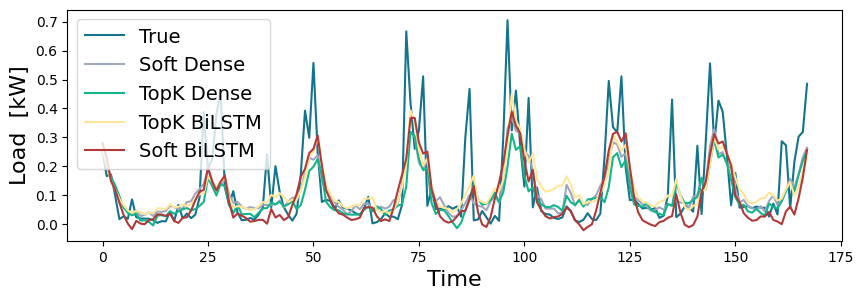

In [19]:
# Plot prediction results
import matplotlib.pyplot as plt

start = 197
stop = start+168
fig = plt.figure(figsize=(10, 3))
plt.plot(y_test[user][start:stop], label='True', color='#13748B')
plt.plot(pred_dense_soft_model[start:stop], label='Soft Dense', color='#A0A7BC')
plt.plot(pred_dense_topk_model[start:stop], label='TopK Dense',color='#13B58B')
plt.plot(pred_bilstm_topk_model[start:stop], label='TopK BiLSTM', color='#FFE699')
plt.plot(pred_bilstm_soft_model[start:stop], label='Soft BiLSTM', color='#B03A3A')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Load  [kW]', fontsize=16)
plt.legend(fontsize=14)